In [13]:
import openmm
from openmm import app, unit
import urllib

In [14]:
urllib.request.urlretrieve(
    "https://files.rcsb.org/view/2Z7F.pdb",
    "2Z7F.pdb"
)

('2Z7F.pdb', <http.client.HTTPMessage at 0x1a0f70520>)

### Structure preparation

In [15]:
from pdbfixer import PDBFixer
fixer = PDBFixer("2Z7F.pdb")
fixer.removeHeterogens(True)
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.addMissingHydrogens(7.0)

In [16]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

In [17]:
modeler = app.Modeller(fixer.topology, fixer.positions)
modeler.addHydrogens(forcefield=forcefield, pH=7.0)
modeler.addSolvent(forcefield=forcefield, padding=1.0*unit.nanometers)

For now on, you should be able to run the simulation and save the output to `output.pdb`,
following the instructions from previous notebook.

💡Hint:
Now the `topology` and `position` are _attributes_ of the `modeler`.

In [18]:
system = forcefield.createSystem(
    modeler.topology, 
    nonbondedMethod=app.PME,
    nonbondedCutoff=1*unit.nanometer, 
    constraints=app.HBonds,
)

In [19]:
integrator = openmm.LangevinIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds,
)

In [20]:
simulation = app.Simulation(modeler.topology, system, integrator)

In [21]:
simulation.context.setPositions(modeler.positions)

In [22]:
simulation.minimizeEnergy()

In [23]:
simulation.reporters.append(app.PDBReporter('output.pdb', 100))
simulation.reporters.append(app.DCDReporter('output.dcd', 50))

In [26]:
#write out modeler to a pdb file (useful for analysis)
app.PDBFile.writeFile(
    modeler.topology, 
    modeler.positions, 
    open('first-frame.pdb', 'w')
)

In [24]:
simulation.step(10000)

As usual, we we carry on to the analysis stage of the simulation.

In [35]:
import mdtraj as md
traj = md.load('output.pdb')

Stability check:

Text(0, 0.5, 'RMSD (nm)')

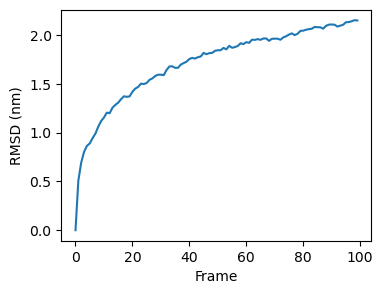

In [36]:
from matplotlib import pyplot as plt
rmsd = md.rmsd(traj, traj, 0)
plt.figure(figsize=(4, 3))
plt.plot(rmsd)
plt.xlabel('Frame')
plt.ylabel('RMSD (nm)')

We can use `MDTraj` to check the distances between atoms,
for example the two nitrogen atons in 41st and 88th residues,
which are 191st and 572nd atoms:

Text(0, 0.5, 'Distance (nm)')

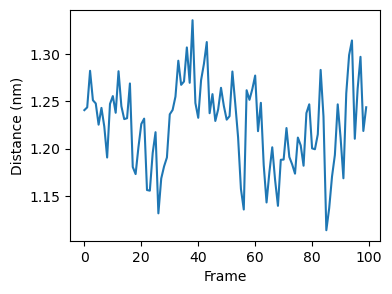

In [38]:
atom0, atom1 = 191, 572
distance = md.compute_distances(traj, [[atom0, atom1]])
plt.figure(figsize=(4, 3))
plt.plot(distance)
plt.xlabel('Frame')
plt.ylabel('Distance (nm)')